In [1]:
import json, os, re
import datetime as dt
from glob import glob
from pprint import pprint
from collections import defaultdict
from bs4 import BeautifulSoup
import pandas as pd

import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from metpy.plots import USCOUNTIES

import sys,re
from pprint import pprint

from harmony import BBox, Client, Collection, Request, Environment, s3_components

# Show the list of jobs in Harmony workflow-ui

In [4]:
harmony_client = Client(env=Environment.UAT)

def show_last_harmony_jobs():
  html = harmony_client.read_text("https://harmony.uat.earthdata.nasa.gov/workflow-ui?limit=100")
  soup = BeautifulSoup(html, 'html.parser')
  data = []
  for tr in soup.table.tbody.find_all("tr"):
    jid = tr.th.text
    tds = tr.find_all("td")
    chain,status,progress = [tds[icol].text for icol in [1,3,5]]
    data.append([jid, chain, status, progress])
  
  return pd.DataFrame(data, columns=["Job Id", "Chain", "Status", "Progress"])

show_last_harmony_jobs()

,Job Id,Chain,Status,Progress
0,755b4b8c-ec29-469e-97b5-fe8fc736dbfa,l2-subsetter-batchee-stitchee-concise,The job has completed successfully,100%
1,f22e1a86-a608-444d-b27f-b93ffcd75e94,podaac/l2-subsetter,The job has completed successfully,100%
2,588e78fc-ceeb-41d3-9fc4-b03df7a8c27a,podaac/l2-subsetter,The job has completed successfully,100%
3,ff23d735-96a6-4460-a678-3f4449a8adce,podaac/l2-subsetter,The job has completed successfully,100%
4,d23a6385-cb79-47da-aa80-742e7883cc5e,l2-subsetter-batchee-stitchee-concise,The job has completed successfully,100%
5,bbf887f5-36b1-41e9-8e41-d3e18bad383d,l2-subsetter-batchee-stitchee-concise,The job has completed successfully,100%
6,624c5471-87dc-4b17-a334-13436dc7f8c9,l2-subsetter-batchee-stitchee-concise,The job has completed successfully,100%
7,aeff0fe7-7555-4a80-9452-494fb5749642,l2-subsetter-batchee-stitchee-concise,The job has completed successfully,100%
8,1bf81fdd-e1fd-4ac4-85cc-5e94b7bf5c7d,l2-subsetter-batchee-stitchee-concise,The job has completed successfully,100%
9,5f620282-020b-4b74-af78-bfb531d8d47e,l2-subsetter-batchee-stitchee-concise,The job has completed successfully,100%


# How to form and submit a request to L2SS-B-S-C chain

In [35]:
def form_request():
  collection = Collection(id='C1254854453-LARC_CLOUD')
  request = Request(
    collection=collection,
    spatial=BBox(-100, 20, -80, 50),
    extend="mirror_step",
    max_results=10
  )
  assert request.is_valid(), "The request is not valid"
  return request
  
def submit_request(request):
  job_id = harmony_client.submit(request)
  return job_id

req = form_request()

jid="6a62b493-71c5-465d-92a5-8025fce44b65"

###################################################################
### Uncomment the following line to proceed with job submission ###
###################################################################
#jid = submit_request(req)

harmony_client.wait_for_processing(jid, show_progress=True)

 [ Processing: 100% ] |###################################################| [|]


# See the detailed status of the job

In [36]:
data=harmony_client.status(jid)
from pprint import pprint
pprint(data)

{'created_at': datetime.datetime(2024, 2, 27, 19, 13, 50, 799000, tzinfo=tzutc()),
 'created_at_local': '2024-02-27T14:13:50-05:00',
 'data_expiration': datetime.datetime(2024, 3, 28, 19, 13, 50, 799000, tzinfo=tzutc()),
 'data_expiration_local': '2024-03-28T15:13:50-04:00',
 'message': 'CMR query identified 66 granules, but the request has been '
            'limited to process only the first 10 granules because you '
            'requested 10 maxResults.',
 'num_input_granules': 10,
 'progress': 100,
 'request': 'https://harmony.uat.earthdata.nasa.gov/C1254854453-LARC_CLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?forceAsync=true&subset=lat(20%3A50)&subset=lon(-100%3A-80)&maxResults=10&extend=mirror_step',
 'status': 'successful',
 'updated_at': datetime.datetime(2024, 2, 27, 19, 25, 51, 349000, tzinfo=tzutc()),
 'updated_at_local': '2024-02-27T14:25:51-05:00'}


In [54]:
try:
  os.mkdir(f"uat/{jid}")
except:
  pass


def show_internal_jobs(jid, download_granules = False):
  html = harmony_client.read_text(f"https://harmony.uat.earthdata.nasa.gov/workflow-ui/{jid}/work-items")
  soup = BeautifulSoup(html, 'html.parser')
  data = []
  for tr in soup.table.tbody.find_all("tr"):
    tds = tr.find_all("td")
    data.append([tds[icol].text for icol in [0,1,2]])

  log_ids = [logid for name,logid,_ in data if 'stitchee' in name or 'batchee' in name or 'concise' in name or 'l2ss-py' in name]
  futs = [harmony_client.download(f"https://harmony.uat.earthdata.nasa.gov/logs/{jid}/{logid}", directory=f"uat/{jid}") for logid in log_ids]
  logs = [fut.result() for fut in futs]
  urls = set()
  for log in logs:
    with open(log) as fin:
      data = json.load(fin)
    for row in data:
      try:
        if 'message' in row and 'download.start' in row['message']:
          url = row['message'].split()[1]
          urls.add(url)
      except:
        pass
  if download_granules:
    futs = [harmony_client.download(url, directory=f"uat/{jid}") for url in urls]
    [fut.result() for fut in futs]
  return pd.DataFrame(data, columns=["service","step id","status"])

df = show_internal_jobs(jid, True)

In [55]:
for url in harmony_client.result_urls(jid):
  fut = harmony_client.download(url, directory=f"uat/{jid}")
  print(fut.result())

uat/6a62b493-71c5-465d-92a5-8025fce44b65/C1254854453-LARC_CLOUD_merged.nc4


In [56]:
grid = []
for ifn,fn in enumerate(glob(f"uat/{jid}/*C12*.nc4")):
  grid.append((ifn, fn, xr.open_dataset(fn).subset_files.data))

In [57]:
def get_XYC(filepath, product_name, index=-1):
  ds_root = xr.open_dataset(filepath)
  ds_product = xr.open_dataset(filepath, group="product")
  ds_geo = xr.open_dataset(filepath, group="geolocation")

  if index<0:
    X, Y, C = ds_geo.longitude.values, ds_geo.latitude.values, ds_product[product_name].values
    filename = filepath
  else:
    X, Y, C = ds_geo.longitude[index].values, ds_geo.latitude[index].values, ds_product[product_name][index].values
    filename = ds_root.subset_files.data[index]
  inds = np.logical_not(np.isnan(X) | np.isnan(Y) | np.isnan(C))

  return filename, X[inds], Y[inds], C[inds]



def plot_map(ax, h2d, vmax=None):
  proj = ccrs.PlateCarree()

  #cmap='terrain_r')
  cmp = plt.cm.terrain_r
  cmp = plt.cm.RdBu_r
  cmp = plt.cm.nipy_spectral_r

  ax.set_extent([-140, -15, 15, 65], crs=proj)

  ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.1, edgecolor='dimgray')
  ax.add_feature(cfeature.OCEAN, linewidth=0.1, edgecolor='dimgray', facecolor='lightsteelblue')
  ax.add_feature(cfeature.LAKES, linewidth=0.1, edgecolor='dimgray', facecolor='lightsteelblue')
  ax.add_feature(cfeature.BORDERS, linewidth=0.1, edgecolor='dimgray')
  ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.1, edgecolor='dimgray')
  ###ax.add_feature(USCOUNTIES.with_scale('20m'), linewidth=0.1)

  (H,xbins,ybins) = h2d
  H=H.T
  ax.pcolormesh(xbins, ybins, H, norm="log", cmap=cmp, alpha=0.8, vmax=vmax)
  return ax


In [58]:
XYCs = defaultdict(list)
for fn in sorted(glob(f"uat/{jid}/TEMPO_*")):
  tm = re.findall("T[^T]*Z",fn)[0]
  kk = re.findall("V01.*S...",fn.replace(tm,""))[0][4:]
  XYCs[kk].append(get_XYC(fn, "vertical_column_total"))


h2ds,bins = {},{}
for kk in XYCs:
  h2ds[kk] = np.histogram2d(np.concatenate([xx for ff,xx,yy,cc in XYCs[kk]]), np.concatenate([yy for ff,xx,yy,cc in XYCs[kk]]), weights=np.concatenate([cc for ff,xx,yy,cc in XYCs[kk]]), bins=200)
  H,xbins,ybins = h2ds[kk]
  bins[kk] = [xbins,ybins,np.max(H)]

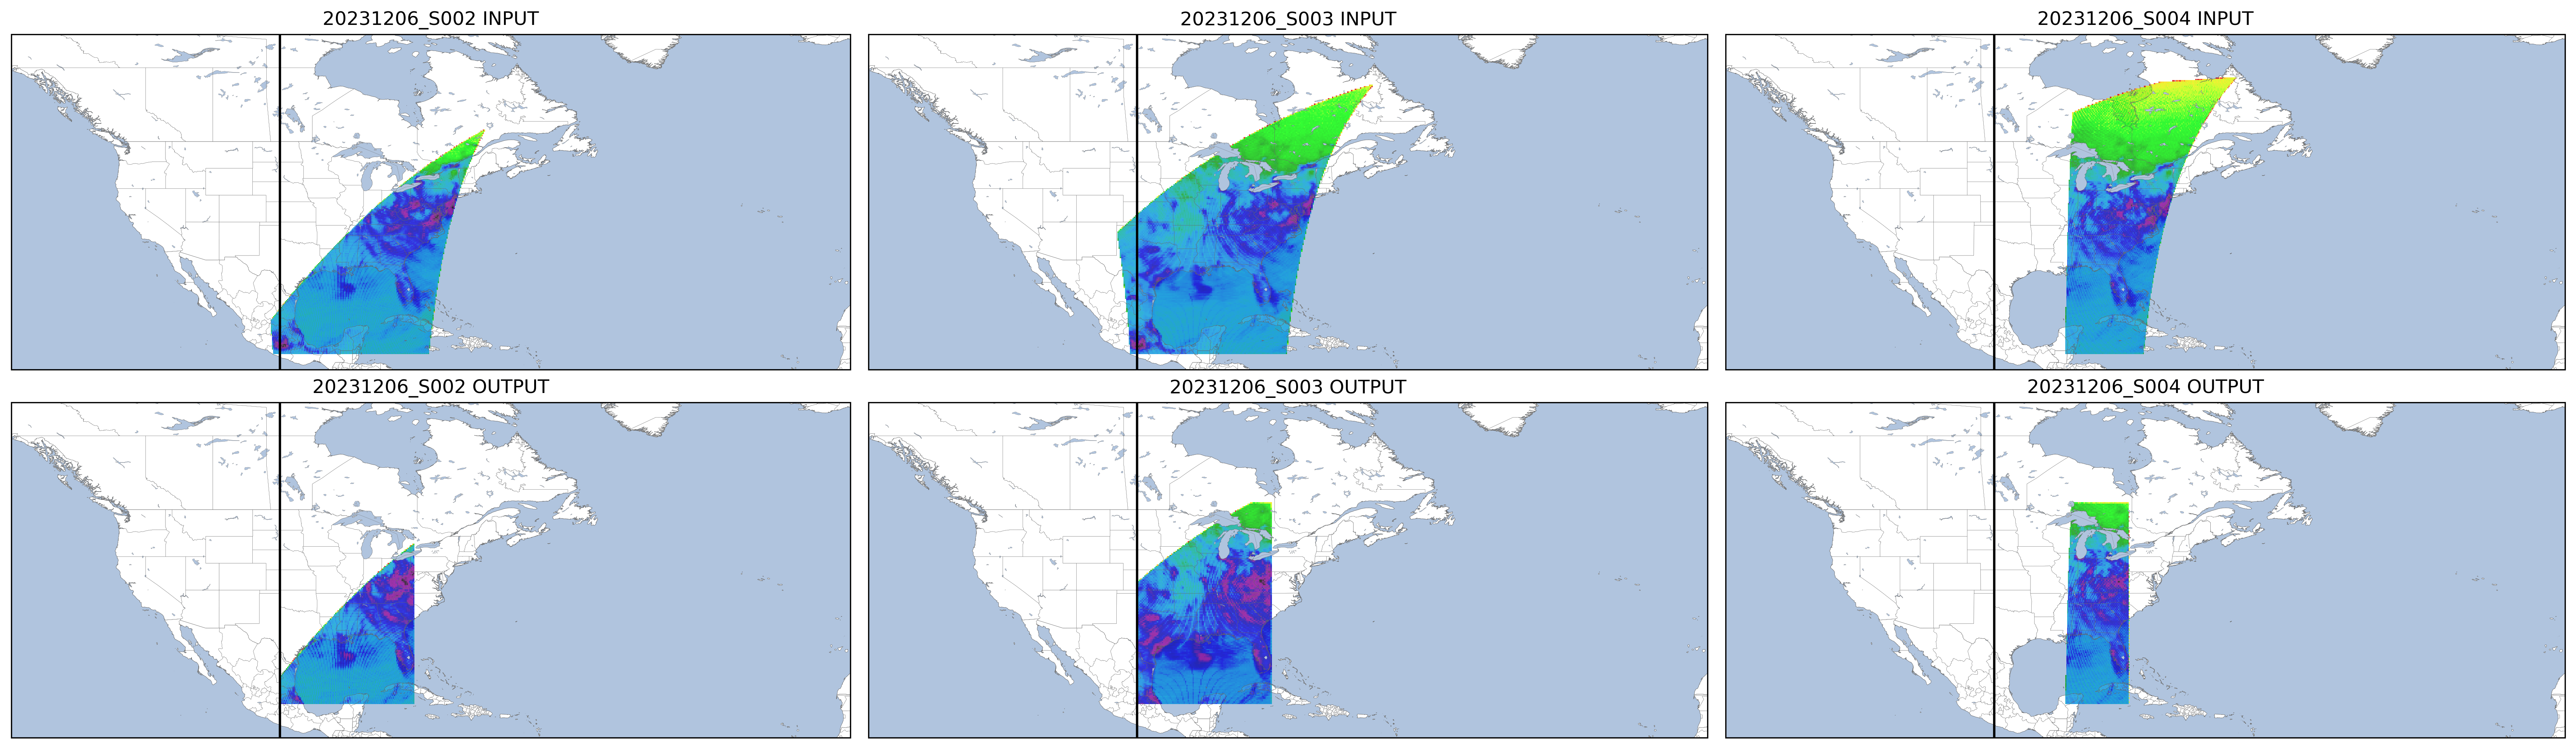

In [60]:
proj = ccrs.PlateCarree()

for ifn,fname,colnames in grid:
  ncols = len(colnames)
  fig, axs = plt.subplots(2, ncols, figsize=(8*ncols, 6.5), dpi=300, facecolor="w", subplot_kw=dict(projection=proj), linewidth=8, edgecolor="white", layout="compressed")
  for icol,colname in enumerate(colnames):
    fn,xx,yy,ww = get_XYC(fname,"vertical_column_total",icol)
    tm = re.findall("T[^T]*Z",fn)[0]
    kk = re.findall("V01.*S...",fn.replace(tm,""))[0][4:]
    xbins,ybinx,vmax = bins[kk]
    h2d = np.histogram2d(xx,yy,bins=[xbins,ybins],weights=ww)

    ax = plot_map(axs[0][icol], h2ds[kk], vmax)
    ax.set_title(kk+" INPUT")
    ax.plot([-100,-100],[15,65],c="black")
    ax = plot_map(axs[1][icol], h2d)
    ax.set_title(kk+" OUTPUT")
    ax.plot([-100,-100],[15,65],c="black")
